In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


In [3]:
df = df[:100]

<Axes: title={'center': "Wikipedia pageviews for 'Peyton Manning'"}, xlabel='ds'>

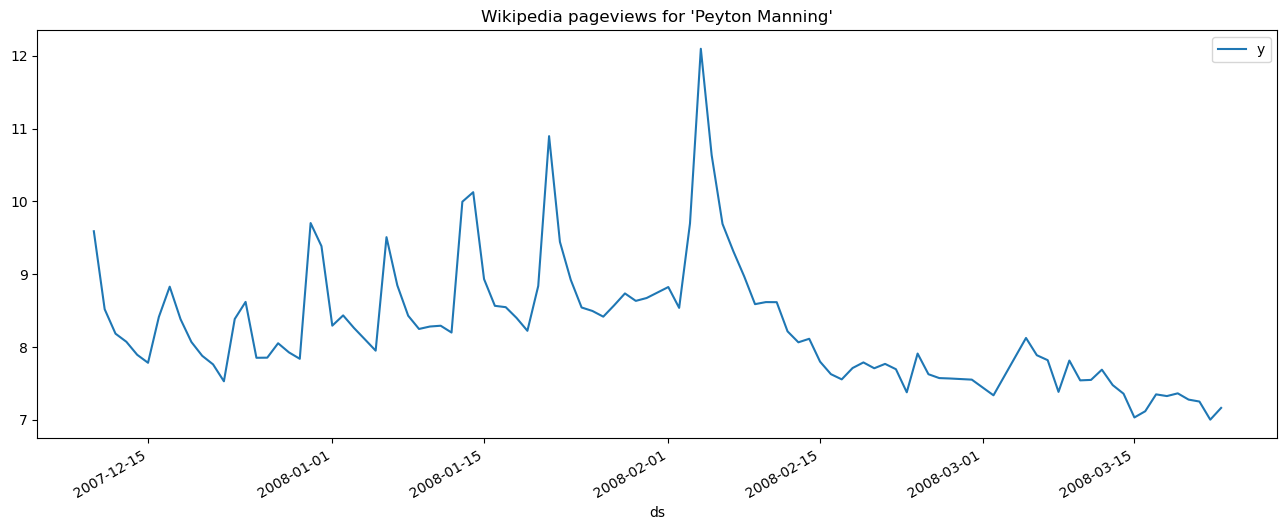

In [4]:
# Make sure we work with datetime types
df['ds'] = pd.to_datetime(df['ds'])
# Scale the data
df['y_scaled'] = df['y'] / df['y'].max()
df['t'] = (df['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())
df.plot(x='ds', y='y', figsize=(16, 6), title="Wikipedia pageviews for 'Peyton Manning'")

In [5]:
df

,ds,y,y_scaled,t
0,2007-12-10,9.590761,0.792792,0.000000
1,2007-12-11,8.519590,0.704246,0.009615
2,2007-12-12,8.183677,0.676479,0.019231
3,2007-12-13,8.072467,0.667286,0.028846
4,2007-12-14,7.893572,0.652498,0.038462
...,...,...,...,...
95,2008-03-19,7.363914,0.608716,0.961538
96,2008-03-20,7.277939,0.601609,0.971154
97,2008-03-21,7.251345,0.599411,0.980769
98,2008-03-22,7.002156,0.578812,0.990385


In [6]:
def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.05, 
                growth_prior_scale=5, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta

        tmp = delta
        g = (k + pyt.tensor.dot(A, delta)) * t + (m + pyt.tensor.dot(A, gamma))
    return g, A, s

# Generate a PyMC3 Model context
m = pm.Model()

with m:
    y, A, s = trend_model(m, np.array(df['t']))
    
    sigma = pm.HalfCauchy('sigma', 0.5, initval=1)
    pm.Normal('obs', 
                 mu=y,
                 sigma=sigma,
                 observed=df['y_scaled'])

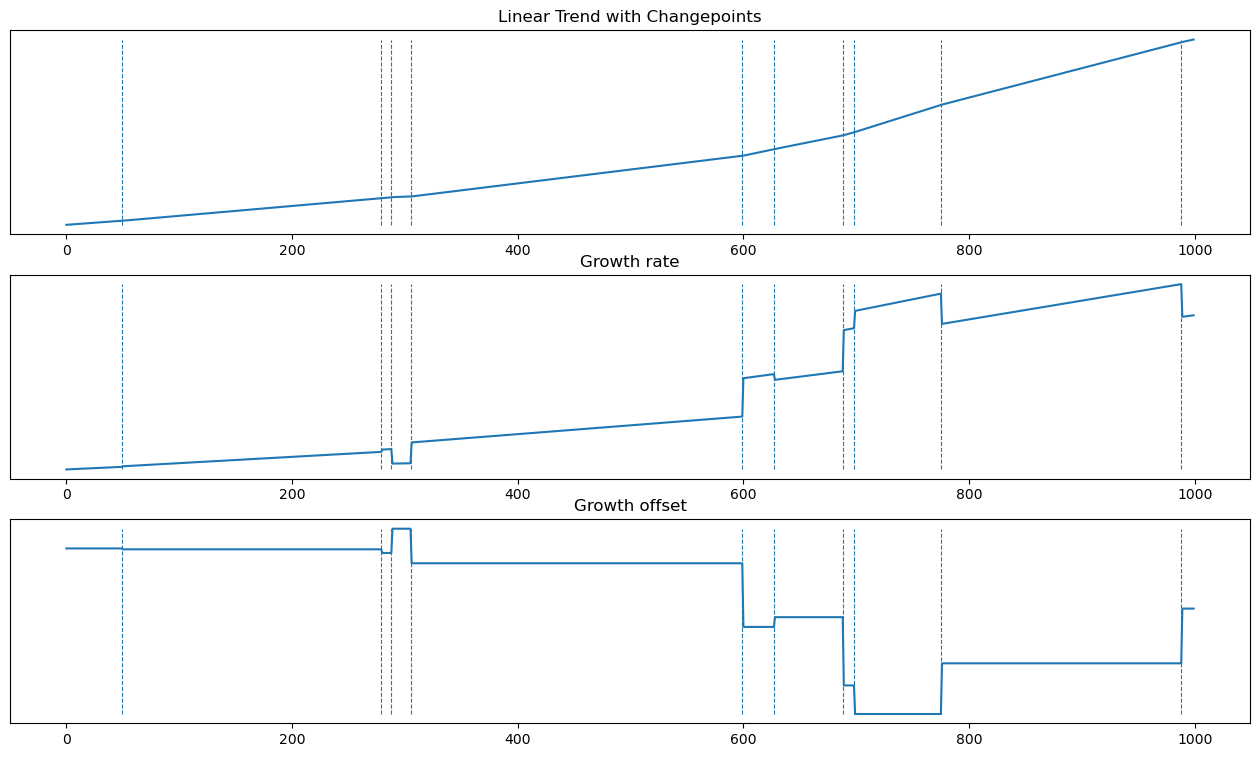

In [8]:
def get_feel():
    np.random.seed(25)
    n_changepoints = 10
    t = np.arange(1000)
    S = np.sort(np.random.choice(t, n_changepoints, replace=False))
    
    A = (t[:, None] > S) * 1
    delta = np.random.normal(size=n_changepoints)
    k = 1
    M = 5
    
    growth = (k + A @ delta) * t
    gamma = -S * delta
    offset = M + A @ gamma
    trend = growth + offset

    return S, trend, growth, offset

_s, _trend, _growth, _offset = get_feel()
plt.figure(figsize=(16, 3 * 3))
_n = 310
_i = 0
for _t, _f in zip(['Linear Trend with Changepoints', 'Growth rate', 'Growth offset'],
                [_trend, _growth, _offset]):
    _i += 1
    plt.subplot(_n + _i)
    plt.title(_t)
    plt.yticks([])
    plt.vlines(_s, min(_f), max(_f), lw=0.8, linestyles='--')
    plt.plot(_f)

Sampling: [delta, k, m, obs, sigma]


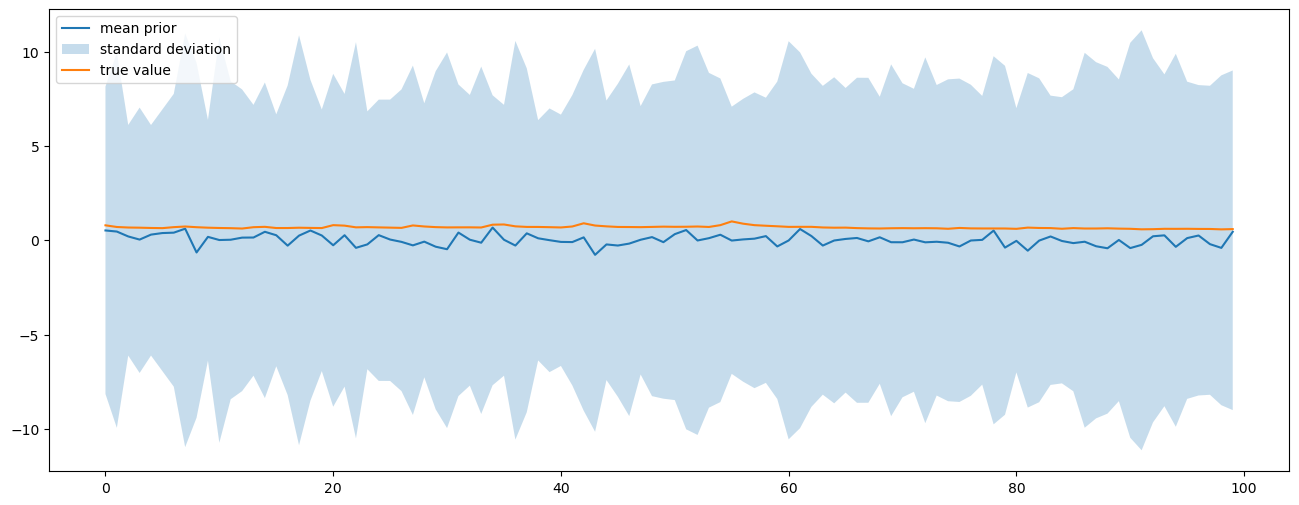

In [7]:
def sanity_check(m, df):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(model=m, var_names=['obs'], return_inferencedata=False)["obs"]
    plt.figure(figsize=(16, 6))
    plt.plot(y.mean(0), label='mean prior')
    plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label='standard deviation')
    plt.plot(df['y_scaled'], label='true value')
    plt.legend()

# And run the sanity check
sanity_check(m, df)

Output()

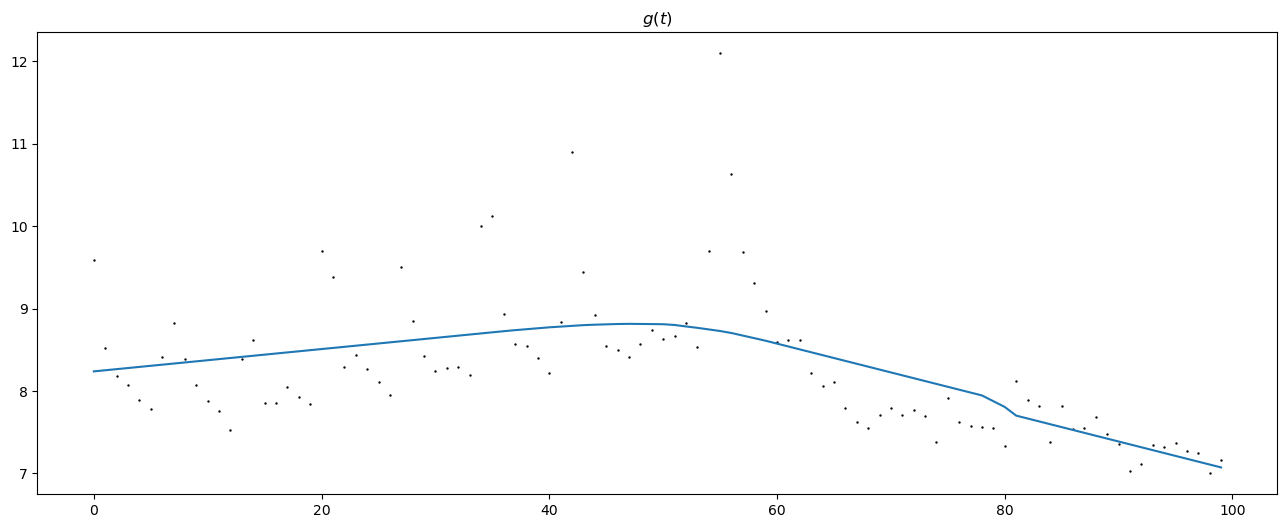

In [8]:
# Find a point estimate of the models parameters
with m:
    aprox = pm.find_MAP()

# Determine g, based on the parameters
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

# run function and rescale to original scale
g = det_trend(aprox['k'], aprox['m'], aprox['delta'], df['t'], s, A) * df['y'].max()

plt.figure(figsize=(16, 6))
plt.title('$g(t)$')
plt.plot(g)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')

In [10]:
with m:
    linear_trace = pm.sample(return_inferencedata=True)
    linear_prior = pm.sample_posterior_predictive(trace=linear_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
Sampling: [obs]


Output()

/tmp/ipykernel_133961/2356269487.py:5: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=100)["obs"],
/tmp/ipykernel_133961/2356269487.py:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"],


KeyError: "No variable named 'trend'. Variables on the dataset include ['k', 'delta_dim_0', 'delta', 'm', 'sigma', 'sample', 'chain', 'draw']"

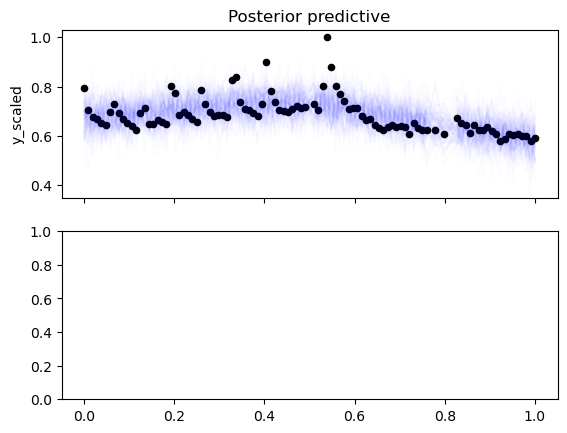

In [16]:
import arviz as az
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["t"],
    az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=100)["obs"],
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="y_scaled", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[1].plot(
    df["t"],
    az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"],
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="y_scaled", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");

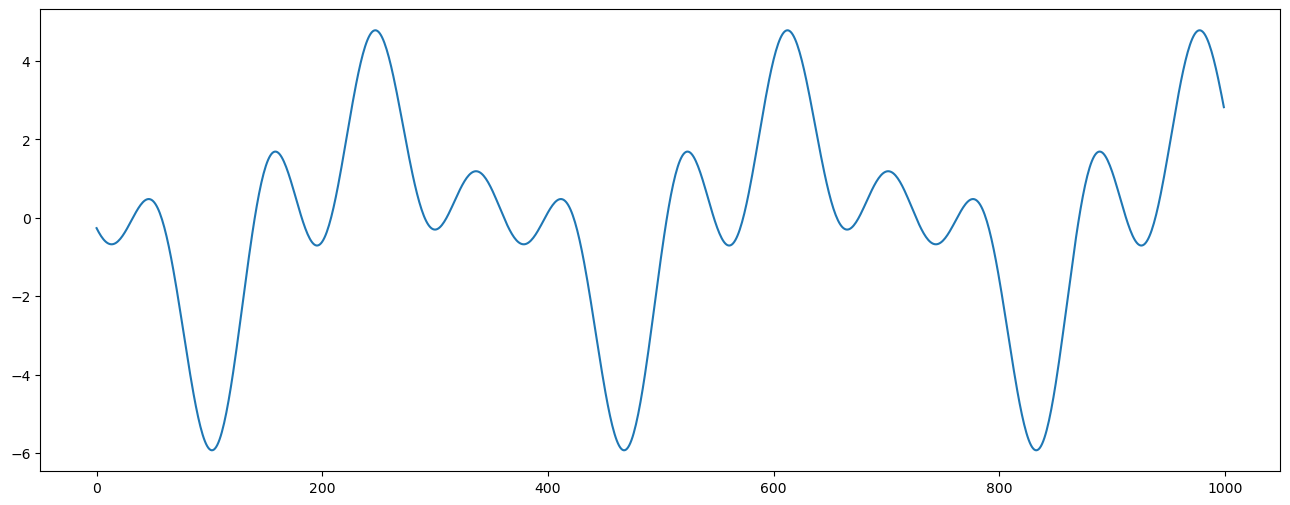

In [11]:
np.random.seed(6)
def fourier_series(t, p=365.25, n=10):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

n = 4
t = np.arange(1000)
beta = np.random.normal(size=2 * n)
plt.figure(figsize=(16, 6))
plt.plot(fourier_series(t, 365.25, n) @ beta)

In [12]:
def seasonality_model(m, df, period='yearly', seasonality_prior_scale=10):
    if period == 'yearly':
        n = 10
        # rescale the period, as t is also scaled
        p = 365.25 / (df['ds'].max() - df['ds'].min()).days
    else:  # weekly
        n = 3
        # rescale the period, as t is also scaled
        p = 7 / (df['ds'].max() - df['ds'].min()).days
    x = fourier_series(np.array(df['t']), p, n)
    with m:
        beta = pm.Normal(f'beta_{period}', mu=0, sigma=seasonality_prior_scale, shape=2 * n)
    return x, beta

m = pm.Model()

with m:
    # changepoints_prior_scale is None, so the exponential distribution
    # will be used as prior on \tau.
    y, A, s = trend_model(m, np.array(df['t']), changepoints_prior_scale=None)
    x_yearly, beta_yearly = seasonality_model(m, df, 'yearly')
    x_weekly, beta_weekly = seasonality_model(m, df, 'weekly')
    
    y += pyt.tensor.dot(x_yearly, beta_yearly) + pyt.tensor.dot(x_weekly, beta_weekly)
    
    sigma = pm.HalfCauchy('sigma', 0.5, initval=1)
    obs = pm.Normal('obs', 
                 mu=y, 
                 sigma=sigma,
                 observed=df['y_scaled'])

In [14]:
with m:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, tau, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1163 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'beta_yearly'}>,
        <Axes: title={'center': 'beta_yearly'}>],
       [<Axes: title={'center': 'beta_weekly'}>,
        <Axes: title={'center': 'beta_weekly'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

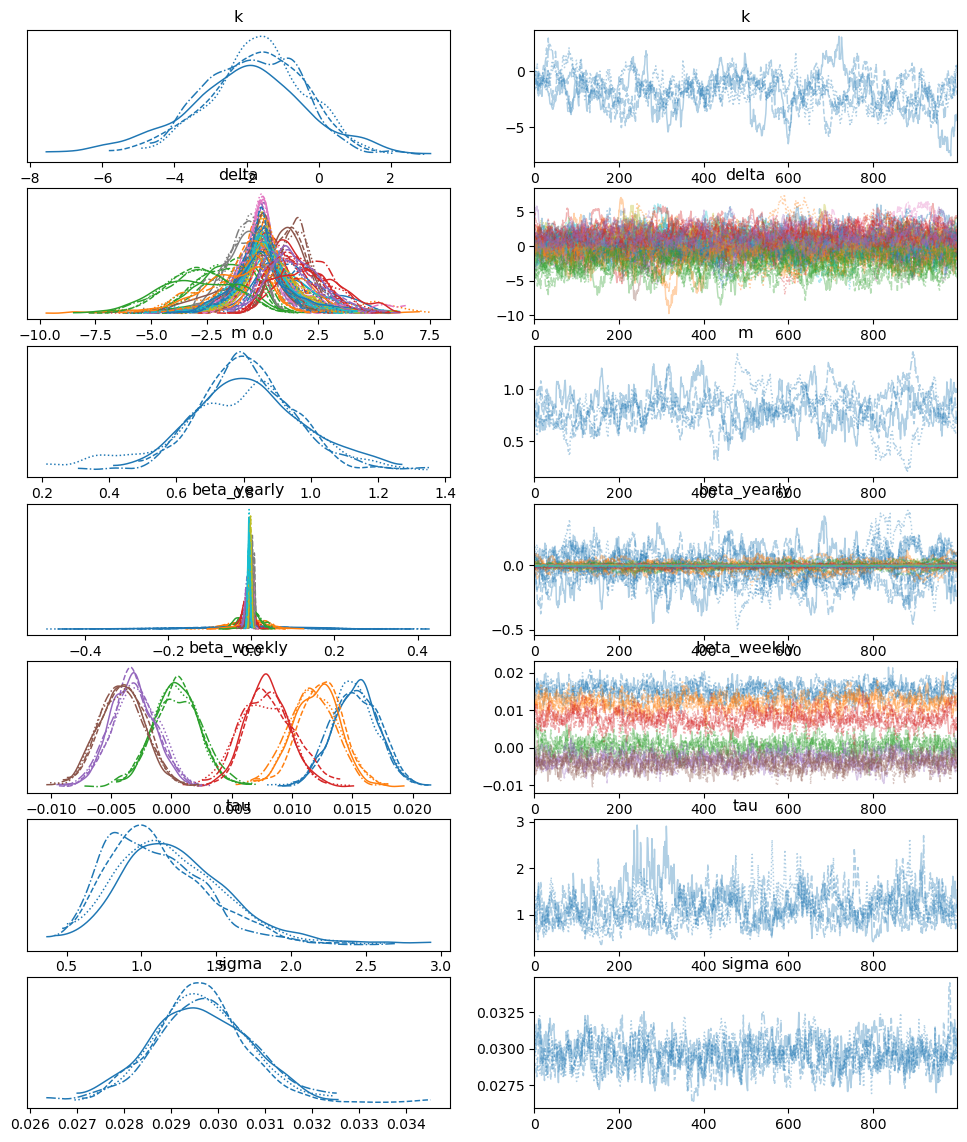

In [15]:
pm.plot_trace(trace)

In [16]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
beta_yearly = trace["posterior"]['beta_yearly']
beta_weekly = trace["posterior"]['beta_weekly']
delta = trace["posterior"]['delta']

# scalar distributions
k = trace["posterior"]['k']
m = trace["posterior"]['m']

# determine the posterior by evaulating all the values in the trace.
trend_posterior = ((k + np.dot(A, delta.T)) * df['t'][:, None] + m + np.dot(A, (-s * delta).T)) * df['y'].max()

yearly_posterior = det_seasonality_posterior(beta_yearly, x_yearly) * df['y'].max()
weekly_posterior = det_seasonality_posterior(beta_weekly, x_weekly) * df['y'].max()

date = df['ds'].dt.to_pydatetime()
sunday = np.argmax(df['ds'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['ds'].dt.dayofyear)

plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date,
         (trend_posterior + yearly_posterior + weekly_posterior).mean(1), lw=0.5)
plt.scatter(date, df['y'], s=0.5, color='black')

plt.subplot(b + 1)
plt.title('trend')
plt.plot(date, trend_posterior.mean(1))
quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

plt.subplot(b + 2)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], yearly_posterior.mean(1)[idx_year: idx_year + 365])
quant = np.quantile(yearly_posterior, [p, 1 - p], axis=1)
plt.fill_between(date[idx_year: idx_year + 365],
                 quant[0, idx_year: idx_year + 365], quant[1, idx_year: idx_year + 365], alpha=0.25)

plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekdays, weekly_posterior.mean(1)[sunday: sunday + 7])
quant = np.quantile(weekly_posterior, [p, 1 - p], axis=1)
plt.fill_between(weekdays, quant[0, sunday: sunday + 7],
                 quant[1, sunday: sunday + 7], alpha=0.25)

ValueError: shapes (500,25) and (25,1000,4) not aligned: 25 (dim 1) != 1000 (dim 1)

In [ ]:
trace["posterior"]

In [ ]:
A.shape, delta.shape

In [ ]:
delta